In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

WindowsPath('C:/Users/cross-entropy/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.623544,0.920729,00:52
1,0.846352,0.671290,00:52
2,0.648493,0.664480,00:51


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

Download the data set, then unzip it into the directory `.fastai/data/`

In [9]:
path=Config.data_path()/'ml-100k'

In [10]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
len(ratings)

100000

In [13]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [14]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [15]:
data.show_batch()

userId,title,target
589,"Game, The (1997)",5.0
885,Michael (1996),3.0
378,"Nightmare Before Christmas, The (1993)",3.0
578,"Devil's Own, The (1997)",3.0
557,"Full Monty, The (1997)",3.0


In [16]:
y_range = [0,5.5]

### Create a collab_learner model with 40 embedded `factors` and fit to the `movielens100k` data
#### This means we are asking the neural network to learn `embeddings` of `movie titles` and of `users` into a 40 dimensional space.  `Embeddings` consist of a 40-dimensional `weight vector` and a `single bias` for each `user` and for each `movie title`. 
#### So the network will `discover` 40 `weights` and a `bias` for each `user` and 40 `weights` and a `bias` for each each `movie title`, and it will be up to us to try to understand what these new `factors` mean.
#### `wd` is the `weight decay parameter`
#### We obtain validation loss of of 0.81 after 5 epochs.

In [17]:
n_factors = 40
learn = collab_learner(data, n_factors=n_factors, y_range=y_range, wd=1e-1)

## Loss seems fairly insensitive to the learning rate!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


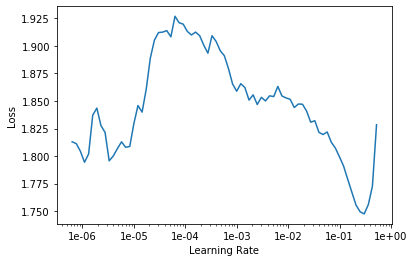

In [18]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [19]:
# are the first and second columns really `train_loss` and `valid_loss`, 
#     or is the second column really`validation error`
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.928998,0.945090,01:00
1,0.873148,0.888399,01:00
2,0.785898,0.837155,01:02
3,0.639292,0.814119,00:59
4,0.551136,0.813251,01:01


### Fit another 5 epochs
#### We obtain validation loss of of 0.86 after another 5 epochs, and training loss is still decreasing.

In [20]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.594999,0.832873,00:59
1,0.705989,0.851596,01:00
2,0.618665,0.836906,00:59
3,0.484571,0.831739,01:00
4,0.386209,0.833441,00:59


In [21]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [22]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [24]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [25]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [27]:
item0 = lambda o:o[0]

In [28]:
# movies with worst ratings
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.4235),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3680),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3442), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.3235), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.3095), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3058), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2910), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2705), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2647), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2576), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2563), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2489), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2469), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2408), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2357), 'Thinner (199

In [29]:
# movies with best ratings
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6445), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6433), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5937), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5761), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5757), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5682), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5547), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5512), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.5409), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5269), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5235), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5193), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5063), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.5028), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4976), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [30]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

### Use `PCA (principal components analysis)` to reduce the dimensionality of the embedding from 40 down to 3. `PCA` works by constructing orthogonal linear combinations of the embeddings (which we will call `factors`)  and ranking them in order of importance. We can then the most influential factors. 

In [31]:
n_factors = 3
movie_pca = movie_w.pca(n_factors)
movie_pca.shape

torch.Size([1000, 3])

In [32]:
factor1,factor2,factor3 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(factor1, top_movies)]

### Genre specified by factor1

In [33]:
# Best movies in genre specified by factor1
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


[(tensor(1.0274), 'Close Shave, A (1995)'),
 (tensor(1.0220), 'Lawrence of Arabia (1962)'),
 (tensor(1.0185), 'Casablanca (1942)'),
 (tensor(0.9820), 'When We Were Kings (1996)'),
 (tensor(0.9765), 'Chinatown (1974)'),
 (tensor(0.9642),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9536), 'Fargo (1996)'),
 (tensor(0.9236), 'Godfather, The (1972)'),
 (tensor(0.9206), 'Wrong Trousers, The (1993)'),
 (tensor(0.9164), 'Ran (1985)')]

In [34]:
# Worst movies in genre specified by factor1
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2373), 'Home Alone 3 (1997)'),
 (tensor(-1.2155), 'Jungle2Jungle (1997)'),
 (tensor(-1.0796), "McHale's Navy (1997)"),
 (tensor(-1.0532), 'Leave It to Beaver (1997)'),
 (tensor(-0.9783), 'Congo (1995)'),
 (tensor(-0.9587), 'Bio-Dome (1996)'),
 (tensor(-0.9407), 'Speed 2: Cruise Control (1997)'),
 (tensor(-0.9202), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-0.9046), 'D3: The Mighty Ducks (1996)'),
 (tensor(-0.8980), 'Batman & Robin (1997)')]

### Genre specified by factor2

In [35]:
movie_comp = [(f, i) for f,i in zip(factor2, top_movies)]
# Best movies in genre specified by factor2
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2311), 'Titanic (1997)'),
 (tensor(1.2305), 'Braveheart (1995)'),
 (tensor(1.0263), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9346), 'Forrest Gump (1994)'),
 (tensor(0.8726), "It's a Wonderful Life (1946)"),
 (tensor(0.8342), "Mr. Holland's Opus (1995)"),
 (tensor(0.8148), 'Independence Day (ID4) (1996)'),
 (tensor(0.8104), 'Back to the Future (1985)'),
 (tensor(0.8095), 'Hunt for Red October, The (1990)'),
 (tensor(0.7978), 'Return of the Jedi (1983)')]

In [36]:
# Worst movies in genre specified by factor2
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8280), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8205), 'Dead Man (1995)'),
 (tensor(-0.7804), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7699), 'Lost Highway (1997)'),
 (tensor(-0.7665), 'Stupids, The (1996)'),
 (tensor(-0.7567), 'Keys to Tulsa (1997)'),
 (tensor(-0.7477), 'Trainspotting (1996)'),
 (tensor(-0.7202), 'Heavenly Creatures (1994)'),
 (tensor(-0.7194), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7188), 'Jude (1996)')]

### Genre specified by factor3

In [37]:
movie_comp = [(f, i) for f,i in zip(factor3, top_movies)]

In [38]:
# Best movies in genre specified by factor3
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9261), 'Postman, The (1997)'),
 (tensor(0.7126), 'Jane Eyre (1996)'),
 (tensor(0.6850), 'Sound of Music, The (1965)'),
 (tensor(0.6543), 'Steel (1997)'),
 (tensor(0.6454), 'Evita (1996)'),
 (tensor(0.6332), 'Wishmaster (1997)'),
 (tensor(0.6029), 'My Fair Lady (1964)'),
 (tensor(0.5856), 'Free Willy 3: The Rescue (1997)'),
 (tensor(0.5798), 'Gone with the Wind (1939)'),
 (tensor(0.5696), 'FairyTale: A True Story (1997)')]

In [39]:
# Worst movies in genre specified by factor3
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9905), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.9768), 'Terminator, The (1984)'),
 (tensor(-0.8477), 'Reservoir Dogs (1992)'),
 (tensor(-0.8058), 'Scream (1996)'),
 (tensor(-0.7890), 'Starship Troopers (1997)'),
 (tensor(-0.7720), 'Pulp Fiction (1994)'),
 (tensor(-0.7579), 'Die Hard (1988)'),
 (tensor(-0.7396), 'Clerks (1994)'),
 (tensor(-0.7393), 'Event Horizon (1997)'),
 (tensor(-0.7353), 'Trainspotting (1996)')]

### Genres `factor1` vs. `factor2`

TypeError: ne() received an invalid combination of arguments - got (str), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mstr[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mstr[0m)


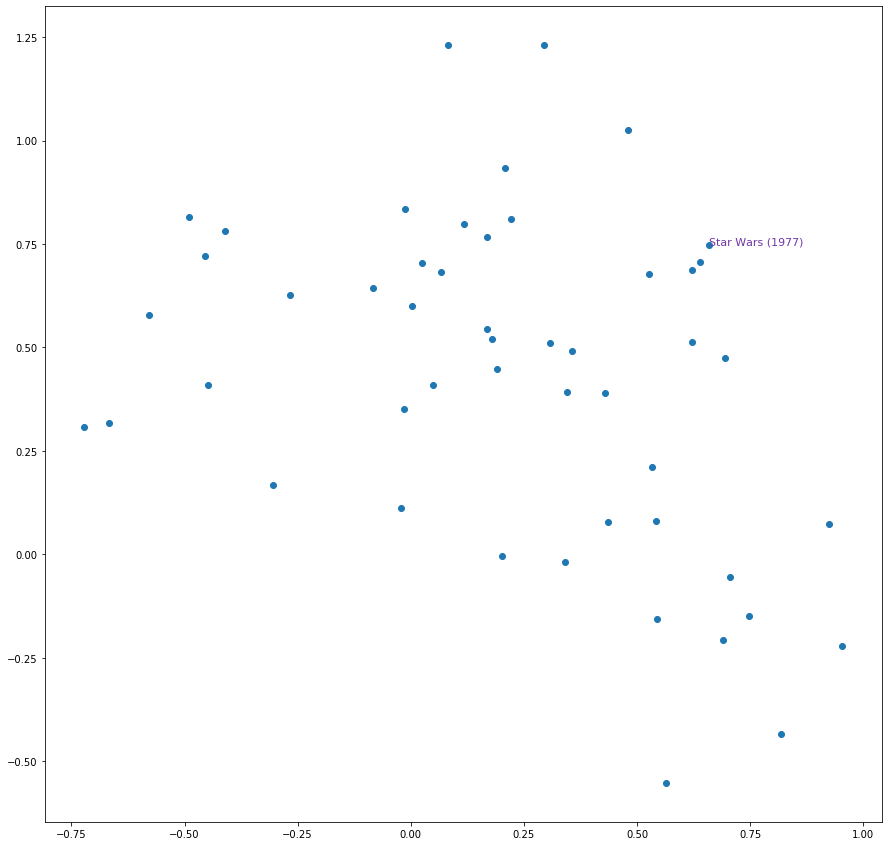

In [40]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = factor1[idxs]
Y = factor2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
    plt.xlabel(factor1)
    plt.ylabel(factor2)
plt.show()

### Genres `factor1` vs. `factor3`

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = factor1[idxs]
Y = factor3[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
    plt.xlabel(factor1)
    plt.ylabel(factor3)
plt.show()

### Genres in `factor2` vs. `factor3`

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = factor2[idxs]
Y = factor3[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
    plt.xlabel(factor2)
    plt.ylabel(factor3)
plt.show()